<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/week2/part3/02_WORKFLOWS_PARALELOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

¿Qué es Pydantic?

Pydantic es una librería de Python para validación de datos y gestión de configuraciones usando anotaciones de tipos de Python. Su lema es: "Data validation using Python type hints".

In [1]:
%pip install -U langchain-google-genai pydantic langgraph
%pip install -U langgraph langchain-google-genai pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.4
    Uninstalling pydantic_core-2.41.4:
      Successfully uninstalled pydantic_core-2.41.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.3
    Uninstalling pydantic-2.12.3:
      Successfully uninstalled pydantic-2.12.3
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.7
    Uninstalling langgraph-1.0.7:
      Successfully uninstalled langgraph-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [2]:
from google.colab import userdata
import os

api_key = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = api_key
print('API Key cargada:', 'Sí' if api_key else 'No')

API Key cargada: Sí


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Configure the Gemini API
MODEL_ID = os.getenv("GEMINI_MODEL", "models/gemini-2.5-flash-lite")

llm = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0.2)
print("✅ LLM listo:", MODEL_ID)

✅ LLM listo: models/gemini-2.5-flash-lite


In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# ============================================================================
# ESTADO DEL GRAFO
# ============================================================================
# Define la estructura de datos compartida entre todos los nodos
class Estado(TypedDict):
    tema: str              # Tema principal sobre el que se generará contenido
    chiste: str            # Chiste generado por el primer LLM
    historia: str          # Historia generada por el segundo LLM
    poema: str             # Poema generado por el tercer LLM
    salida_combinada: str  # Resultado final que combina todos los contenidos

In [5]:
# ============================================================================
# NODOS - Funciones que ejecutan tareas específicas
# ============================================================================

def llamar_llm_1(estado: Estado):
    """
    Primera llamada al LLM: Genera un chiste
    - Recibe el tema del estado compartido
    - Retorna el chiste generado
    """
    mensaje = llm.invoke(f"Escribe un chiste sobre {estado['tema']}")
    return {"chiste": mensaje.text}

def llamar_llm_2(estado: Estado):
    """
    Segunda llamada al LLM: Genera una historia
    - Se ejecuta en paralelo con llamar_llm_1 y llamar_llm_3
    - Retorna la historia generada
    """
    mensaje = llm.invoke(f"Escribe una historia sobre {estado['tema']}")
    return {"historia": mensaje.text}

def llamar_llm_3(estado: Estado):
    """
    Tercera llamada al LLM: Genera un poema
    - También se ejecuta en paralelo
    - Retorna el poema generado
    """
    mensaje = llm.invoke(f"Escribe un poema sobre {estado['tema']}")
    return {"poema": mensaje.text}

def agregador(estado: Estado):
    """
    Combina todos los resultados en una sola salida formateada
    - Espera a que los 3 LLMs terminen (punto de sincronización)
    - Organiza el contenido en un formato legible
    """
    combinado = f"¡Aquí tienes una historia, un chiste y un poema sobre {estado['tema']}!\n\n"
    combinado += f"HISTORIA:\n{estado['historia']}\n\n"
    combinado += f"CHISTE:\n{estado['chiste']}\n\n"
    combinado += f"POEMA:\n{estado['poema']}"
    return {"salida_combinada": combinado}

In [6]:
# ============================================================================
# CONSTRUCCIÓN DEL FLUJO DE TRABAJO PARALELO
# ============================================================================

# Crear el constructor del grafo con el esquema de Estado
constructor_paralelo = StateGraph(Estado)

# ----------------------------------------------------------------------------
# Agregar nodos al grafo
# ----------------------------------------------------------------------------
constructor_paralelo.add_node("llamar_llm_1", llamar_llm_1)
constructor_paralelo.add_node("llamar_llm_2", llamar_llm_2)
constructor_paralelo.add_node("llamar_llm_3", llamar_llm_3)
constructor_paralelo.add_node("agregador", agregador)

# ----------------------------------------------------------------------------
# Agregar conexiones (edges) entre nodos
# ----------------------------------------------------------------------------

# EJECUCIÓN PARALELA: Las 3 llamadas al LLM inician simultáneamente desde START
constructor_paralelo.add_edge(START, "llamar_llm_1")  # Rama 1: Generar chiste
constructor_paralelo.add_edge(START, "llamar_llm_2")  # Rama 2: Generar historia
constructor_paralelo.add_edge(START, "llamar_llm_3")  # Rama 3: Generar poema

# PUNTO DE SINCRONIZACIÓN: Las 3 ramas convergen en el agregador
# El agregador espera a que todos los LLMs terminen antes de ejecutarse
constructor_paralelo.add_edge("llamar_llm_1", "agregador")
constructor_paralelo.add_edge("llamar_llm_2", "agregador")
constructor_paralelo.add_edge("llamar_llm_3", "agregador")

# El agregador termina el proceso
constructor_paralelo.add_edge("agregador", END)

# ----------------------------------------------------------------------------
# Compilar el grafo en una cadena ejecutable
# ----------------------------------------------------------------------------
flujo_paralelo = constructor_paralelo.compile()


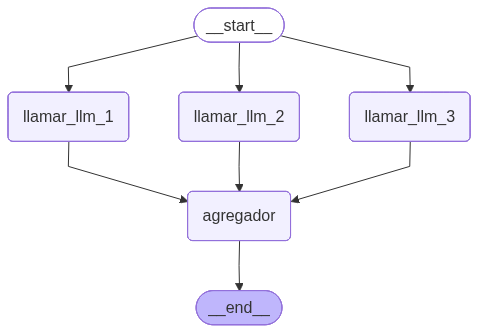

In [7]:
# ============================================================================
# VISUALIZACIÓN
# ============================================================================

# Mostrar el diagrama del flujo de trabajo
display(Image(flujo_paralelo.get_graph().draw_mermaid_png()))

In [8]:
# ============================================================================
# EJECUCIÓN
# ============================================================================

# Ejecutar el flujo con el tema "gatos"
estado = flujo_paralelo.invoke({"tema": "gatos"})

# Imprimir el resultado final combinado
print(estado["salida_combinada"])

¡Aquí tienes una historia, un chiste y un poema sobre gatos!

HISTORIA:
Claro, aquí tienes una historia sobre gatos:

En el corazón de una ciudad bulliciosa, donde los rascacielos se alzaban como gigantes de cristal y el rugido del tráfico era una sinfonía constante, vivía un gato llamado Sombra. No era un gato cualquiera. Sombra era un felino de pelaje negro azabache, tan profundo que parecía absorber la luz a su alrededor, con ojos de un verde esmeralda que brillaban con una inteligencia ancestral.

Sombra no tenía un hogar fijo. Era un espíritu libre, un vagabundo de los tejados, un observador silencioso de la vida humana que se desarrollaba a continuación. Conocía cada callejón, cada tejado, cada rincón secreto de la ciudad. Sus días transcurrían entre siestas bajo el sol tibio en los alféizares de las ventanas, cacerías sigilosas de ratones en los almacenes abandonados y conversaciones silenciosas con otros gatos del vecindario.

Había un lugar en particular que Sombra amaba: una 